In [1]:
import fitsio
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.table as t
# importing all modules
import os
import fitsio
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
import numpy as np
import astropy.table as t
import subprocess
import json 
import scipy.optimize as so
from scipy.integrate import odeint
import numpy.ma as ma
from scipy.stats import linregress
import pandas as pd
from scipy.stats import binned_statistic as bn
import pickle
import h5py
import redrock.templates

In [2]:
# function definitions
def read_tile_catalog(tile_string):
    # Read galaxy catalog of a tile including line fit information of all objects
    # input: string with the ID of the tile, e.g. "80605"
    # returns: structured array with catalog of all objects in that tile
    
    emlist = glob.glob('/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/'+tile_string+'/*/emline*.fits')
    emtable = t.Table()
    for filename in emlist:
        emread2=fits.open(filename)
        dumtable=t.Table.read(emread2[1])
        dumtable['RRFN']=dumtable.meta['RRFN']
        dumtable['FN']=filename
        dumtable['COADDFN']=dumtable.meta['COADDFN']
        emtable=t.vstack([dumtable,emtable])
    
    return emtable

def filter_galaxies(catalog):
    # Filter catalog to only include galaxy targets among spectype and targets among different, return the filtered catalog
    return catalog[(catalog['SPECTYPE']=='GALAXY') & (catalog['OBJTYPE']=='TGT')]

def filter_good_fits(catalog, deltachi2=40):
    # Filter catalog to only include targets with no ZWARN flag and good deltachi2
    
    good = (catalog['ZWARN'] == 0) & (catalog['DELTACHI2']>deltachi2)
    return catalog[good]
def filter_badoiii(catalog,oIIIlimit=-3):
    badoiii= (catalog['OIII_FLUX']*catalog['OIII_FLUX_IVAR']**0.5 < oIIIlimit)
    return(catalog[badoiii])
     

def calculate_oii_oiii_matrix(catalog, oIIlimit=-3, oIIIlimit=-3):
    
    # return normalized matrix of whether OII and OIII fluxes are or are not compatible with physical fit
    
    matrix = np.zeros(4)
    # ordered as 'OII good, OIII good', 'good, bad', 'bad, good', 'bad, bad' where bad means the significance of the respective flux is smaller than the limit passed to the function
    
    select = (catalog['OII_FLUX']*catalog['OII_FLUX_IVAR']**0.5 > oIIlimit) & (catalog['OIII_FLUX']*catalog['OIII_FLUX_IVAR']**0.5 > oIIIlimit)
    matrix[0] = np.sum(select)
    
    select = (catalog['OII_FLUX']*catalog['OII_FLUX_IVAR']**0.5 > oIIlimit) & (catalog['OIII_FLUX']*catalog['OIII_FLUX_IVAR']**0.5 <= oIIIlimit)
    matrix[1] = np.sum(select)
    
    select = (catalog['OII_FLUX']*catalog['OII_FLUX_IVAR']**0.5 <= oIIlimit) & (catalog['OIII_FLUX']*catalog['OIII_FLUX_IVAR']**0.5 > oIIIlimit)
    matrix[2] = np.sum(select)
    
    select = (catalog['OII_FLUX']*catalog['OII_FLUX_IVAR']**0.5 <= oIIlimit) & (catalog['OIII_FLUX']*catalog['OIII_FLUX_IVAR']**0.5 <= oIIIlimit)
    matrix[3] = np.sum(select)
    
    return matrix/np.sum(matrix)


def plot_matrices(matrices):
    
    matrices = np.array(matrices)
    
    # plt.hist(matrices[:,0], label="good OII & OIII",color='blue') hidden because we expect it to be -> 1
    plt.hist(matrices[:,1], label="good OII, bad OIII",bins=(np.linspace(0,0.1,100)),alpha=0.5)
    plt.hist(matrices[:,2], label="bad OII, good OIII",bins=(np.linspace(0,0.1,100)),alpha=0.5)
    plt.hist(matrices[:,3], label="bad OII & OIII",bins=(np.linspace(0,0.1,100)),alpha=0.5)
    plt.legend()
    plt.xlabel('Fraction of Galaxies')
    plt.ylabel('Frequency')

def calculateoiilinestrength(catalog):
    return (np.array(catalog['OII_FLUX']*catalog['OII_FLUX_IVAR']**0.5))

def calculateoiiilinestrength(catalog):
    return (np.array(catalog['OIII_FLUX']*catalog['OIII_FLUX_IVAR']**0.5))
    
def getdchi2(catalog):
    return (catalog['DELTACHI2'])

In [2]:
# tiles used for analysis
tiles=["80653","80654","80655","80656","80657","80658","80659","80660","80661","80662","80663","80664","80665","80666","80669","80670","80673","80674","80675","80676","80677","80678","80679","80680","80681","80682","80683","80684","80685","80686","80687","80688","80689","80690","80691","80692","80693","80694","80695","80696","80697","80698","80699","80700","80701","80702","80703","80705","80706","80707","80708","80709","80710","80711","80712","80715","80718","80719","80720","80721","80722","80724","80726","80728","80729","80730","80731","80732","80733","80734","80735","80736","80737","80738","80740","80741","80742","80782","80783","80784","80785","80786","80787","80788","80789","80790","80856","80857","80858","80859","80860","80861","80862","80863","80865","80866","80867","80869","80870","80871","80872","80873","80875","80876","80879","80882","80885","80886","80887","80888","80889","80890","80891","80892","80893","80894","80895","80896","80897","80898","80899","80900","80901","80902","80938","80944","80949","80950","80951","80952","80954","80955","80956","80958","80959","80960","80962","80963","80966","80968","80970","80971","80972","80974","80975","81000","81001","81002","81003","81004","81005","81006","81007","81008","81009","81010","81011","81012","81013","81014","81015","81022","81056","81057","81058","81059","81060","81061","81062","81063","81064","81065","81066","81067","81068","81069","81072","81073","81074","81075","81088","81097","81098","81099","81100","81101","81102","81103","81104","81105","81106","81107","81108","81109","81110","81111","81112","81113","81114","81115"]
# tiles=['81115'] # if you want to test a particular file

In [29]:
# filtering targets according to choice
badoiii=t.Table()
megacatalog=t.Table()
for tile in tiles:
    print(tile)
    catalog = read_tile_catalog(tile)
    catalog = filter_galaxies(catalog)
    # catalog = filter_good_fits(catalog)
    megacatalog=t.vstack([catalog,megacatalog])
    catalog = filter_badoiii(catalog)
    badoiii=t.vstack([catalog,badoiii])

80653


80654


80655


80656


80657


80658


80659


80660


80661


80662


80663


80664


80665


80666


80669


80670


80673


80674


80675


80676


80677


80678


80679


80680


80681


80682


80683


80684


80685


80686


80687


80688


80689


80690


80691


80692


80693


80694


80695


80696


80697


80698


80699


80700


80701


80702


80703


80705


80706


80707


80708


80709


80710


80711


80712


80715


80718


80719


80720


80721


80722


80724


80726


80728


80729


80730


80731


80732


80733


80734


80735


80736


80737


80738


80740


80741


80742


80782


80783


80784


80785


80786


80787


80788


80789


80790


80856


80857


80858


80859


80860


80861


80862


80863


80865


80866


80867


80869


80870


80871


80872


80873


80875


80876


80879


80882


80885


80886


80887


80888


80889


80890


80891


80892


80893


80894


80895


80896


80897


80898


80899


80900


80901


80902


80938


80944


80949


80950


80951


80952


80954


80955


80956


80958


80959


80960


80962


80963


80966


80968


80970


80971


80972


80974


80975


81000


81001


81002


81003


81004


81005


81006


81007


81008


81009


81010


81011


81012


81013


81014


81015


81022


81056


81057


81058


81059


81060


81061


81062


81063


81064


81065


81066


81067


81068


81069


81072


81073


81074


81075


81088


81097


81098


81099


81100


81101


81102


81103


81104


81105


81106


81107


81108


81109


81110


81111


81112


81113


81114


81115


In [ ]:
# Pickling data
data = {'badoiii': badoiii,
    'dchi2': dchi2,
     'megacatalog':megacatalog
       }
with open('datapenaltymega.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


In [2]:
# Extracting and displaying pickled data
with open('datapenalty.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    penalty = pickle.load(f)

for i in penalty:
    print(i)
    

badoiii
dchi2
penbadoiii
megacatalog


In [3]:
catalog=penalty['megacatalog']

In [4]:
len(catalog)

412154

In [5]:
filename = catalog['FN']
rr=[]
for i in filename:
 s=i.replace('emline','rrdetails')
 n=s.replace('fits','h5')
 rr.append(n)
catalog['RRN']=rr

In [ ]:
# finding the data
outdict={}
g=[]
for fn in np.unique(catalog['COADDFN']):
    entries=catalog[catalog['COADDFN']==fn]
    fnrr=entries['RRFN'][0]
    rrf=fitsio.FITS(fnrr)
    fobj=fitsio.FITS(fn)
    fm=fobj['FIBERMAP']
    tids=fm['TARGETID'][:]
    for entry in entries:
        if entry['TARGETID'] in tids:
            index=(fm['TARGETID'][:]==entry['TARGETID']).nonzero()[0]
            g.append(entry['TARGETID'])
            # print(index, entry['TARGETID'])
            outdict[entry['TARGETID']]={'wave':[],'flux':[],'ivar':[],'mask':[],'redshift':rrf['REDSHIFTS']['Z'][index],'petal':fn.split('/')[-1].split('-')[1],'tile':fn.split('/')[-1].split('-')[2]}            
            for color in 'BRZ':
                outdict[entry['TARGETID']]['wave'].append(fobj[f'{color}_WAVELENGTH'][:])
                outdict[entry['TARGETID']]['flux'].append(fobj[f'{color}_FLUX'][index:index+1,:][0])
                outdict[entry['TARGETID']]['ivar'].append(fobj[f'{color}_IVAR'][index:index+1,:][0])
                outdict[entry['TARGETID']]['mask'].append(fobj[f'{color}_MASK'][index:index+1,:][0])    


In [9]:
np.shape(z)

(0,)

In [10]:
so=catalog['TARGETID']
# so.sort()
# tid.sort()
print(tid==so)


False


In [9]:
#finding the model
mi=[]
xi=[]
tid=[]
z=[]
chi2=[]
templates = dict()
for filename in redrock.templates.find_templates():
    l = redrock.templates.Template(filename) #check if you can add a "verbose=False"
    templates[(l.template_type, l.sub_type)] = l
templates[('QSO','')]=redrock.templates.Template('rrtemplate-qso.fits')
for i,filename in enumerate(catalog['RRN']):
            data = h5py.File(filename, mode='r')
            zfit = t.Table(np.array(data['zfit'][str(catalog['TARGETID'][i])]['zfit']))
            # coeff_1=zfit['coeff'][0]
            # z_1=zfit['z'][0]
            tid.append(catalog['TARGETID'][i])
            tflux=[]
            twave=[]
            zmod=[]
            chi2sintar=[]
            for p in range(0,len(zfit['z'])):
             fulltype=((zfit['spectype'][p],zfit['subtype'][p]))
             # print(fulltype)
             tflux.append(templates[fulltype].flux.T.dot(zfit['coeff'][p][:templates[fulltype].flux.shape[0]]))
             twave.append(templates[fulltype].wave * (1+zfit['z'][p]))
             zmod.append(zfit['z'][p])
             chi2sintar.append(zfit['chi2'][p])
            mi.append(tflux)   #these become list of lists now of shape(mod,cat)
            xi.append(twave) #these become list of lists now of shape(mod,cat)
            z.append(zmod) #these become list now of shape(mod,cat)
            chi2.append(chi2sintar) #these become list now of shape(mod,cat)
print(len(zfit['z']))



DEBUG: Read templates from /global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/code/redrock-templates/main
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using redshift range 1.4000-6.9930 for rrtemplate-qso-HIZ.fits
DEBUG: Using redshift range 0.0500-1.5983 for rrtemplate-qso-LOZ.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits
DEBUG: Using default redshift range 

In [8]:
z

NameError: name 'z' is not defined

In [ ]:
templates

{('GALAXY', ''): <redrock.templates.Template at 0x15441be6f700>,
 ('QSO', 'HIZ'): <redrock.templates.Template at 0x1543b3b76e80>,
 ('QSO', 'LOZ'): <redrock.templates.Template at 0x154441edf2b0>,
 ('STAR', 'A'): <redrock.templates.Template at 0x1543b3acdd30>,
 ('STAR', 'B'): <redrock.templates.Template at 0x154440109c40>,
 ('STAR', 'CV'): <redrock.templates.Template at 0x1543b3b10490>,
 ('STAR', 'F'): <redrock.templates.Template at 0x1543b3b156d0>,
 ('STAR', 'G'): <redrock.templates.Template at 0x1543b3aca100>,
 ('STAR', 'K'): <redrock.templates.Template at 0x1543b3b153a0>,
 ('STAR', 'M'): <redrock.templates.Template at 0x1543b3aca190>,
 ('STAR', 'WD'): <redrock.templates.Template at 0x1543b3aca6a0>,
 ('QSO', ''): <redrock.templates.Template at 0x1543b3b150a0>}

/tmp/ipykernel_212409/3890075861.py:54: RuntimeWarning: invalid value encountered in true_divide
  merdatline=np.array(binwdatline)/np.array(binsigline)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_212409/3890075861.py:54: RuntimeWarning: invalid value encountered in true_divide
  merdatline=np.array(binwdatline)/np.array(binsigline)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists 

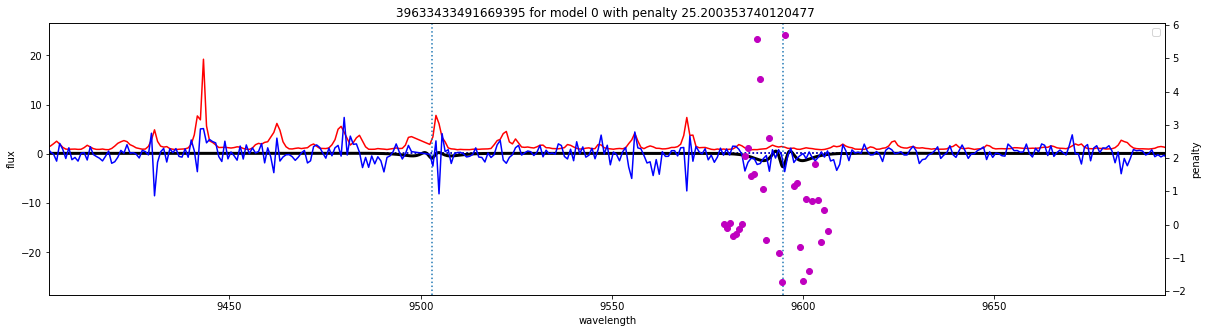

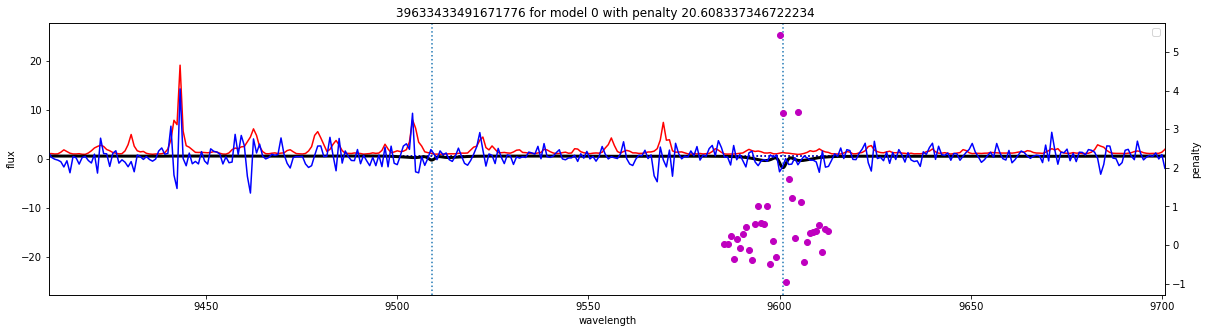

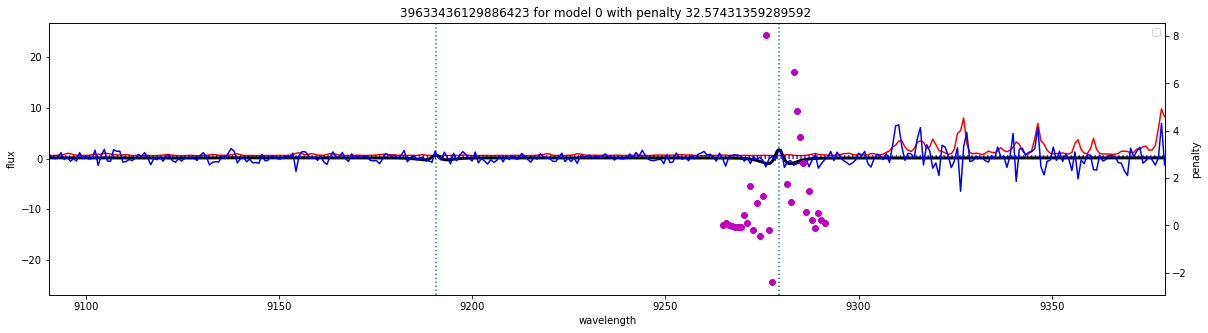

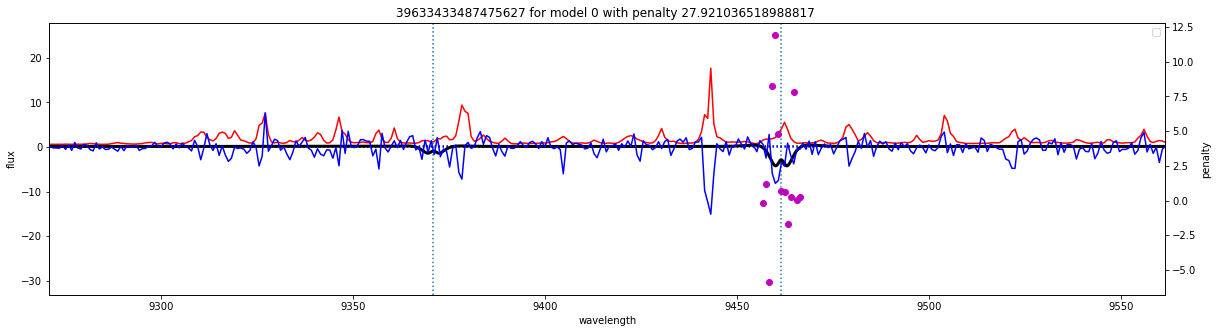

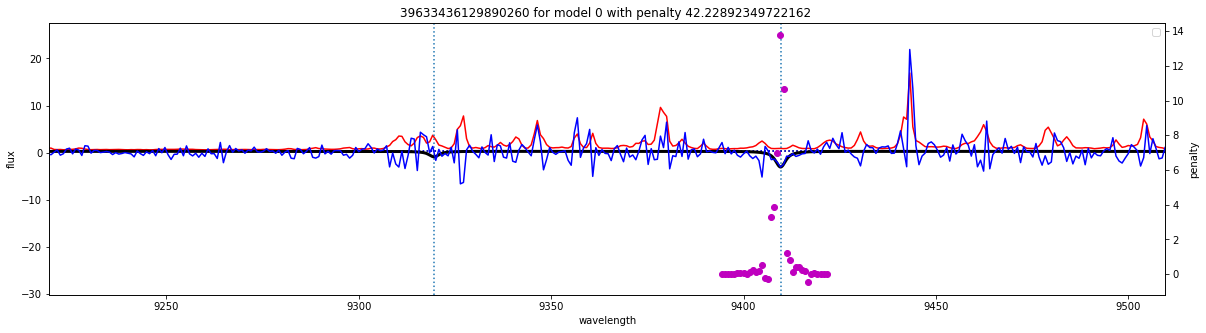

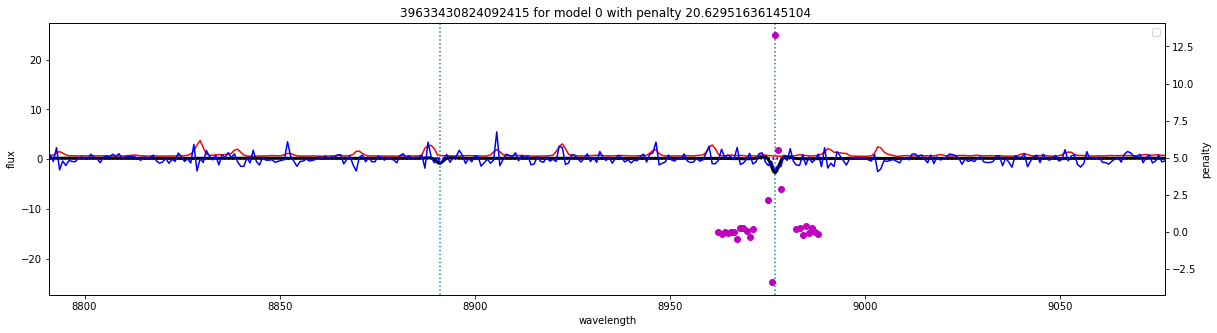

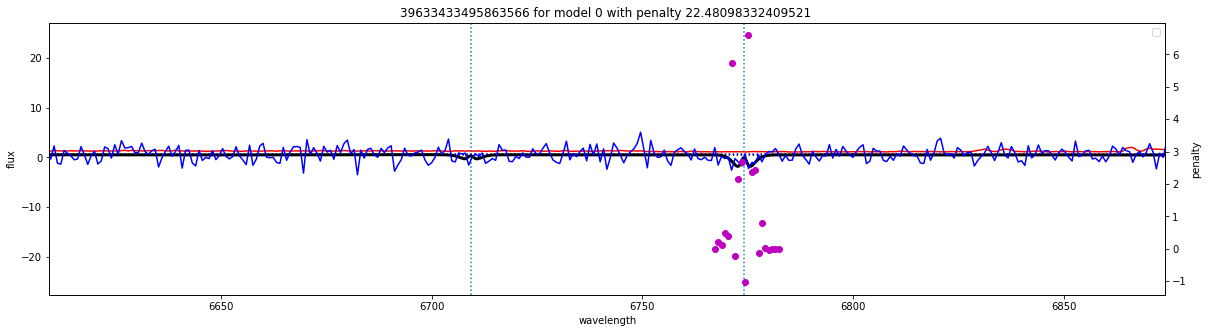

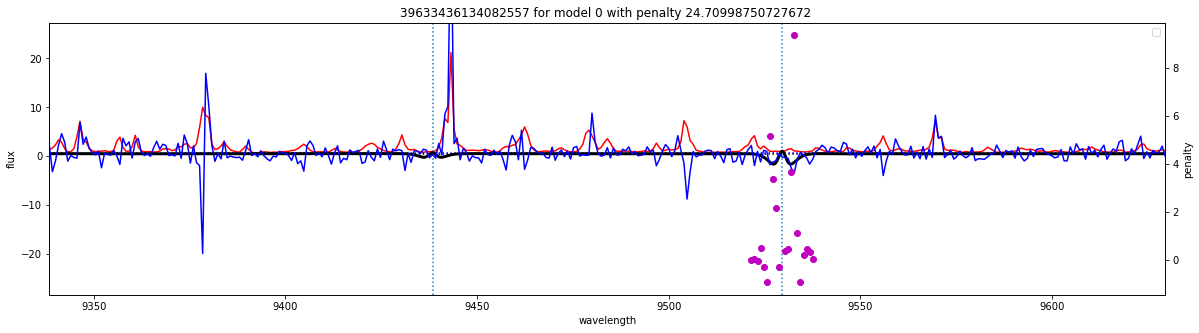

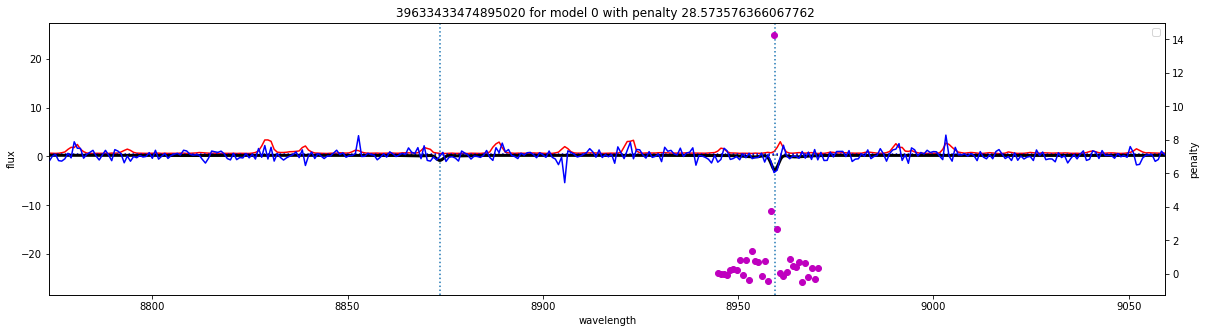

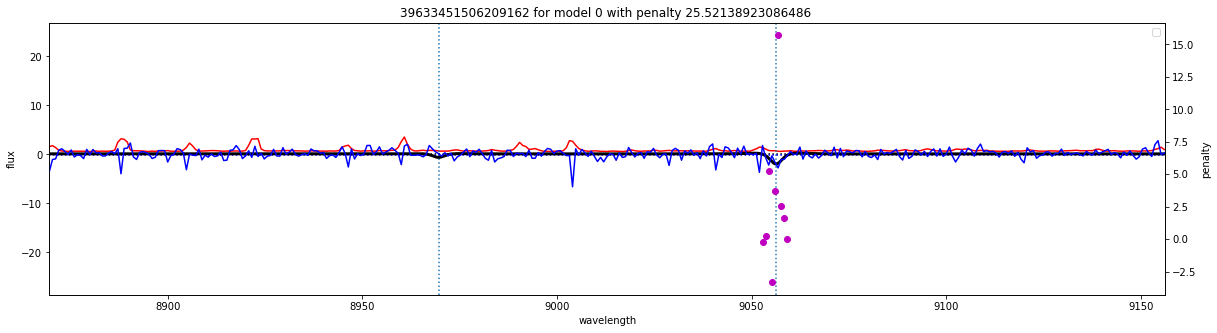

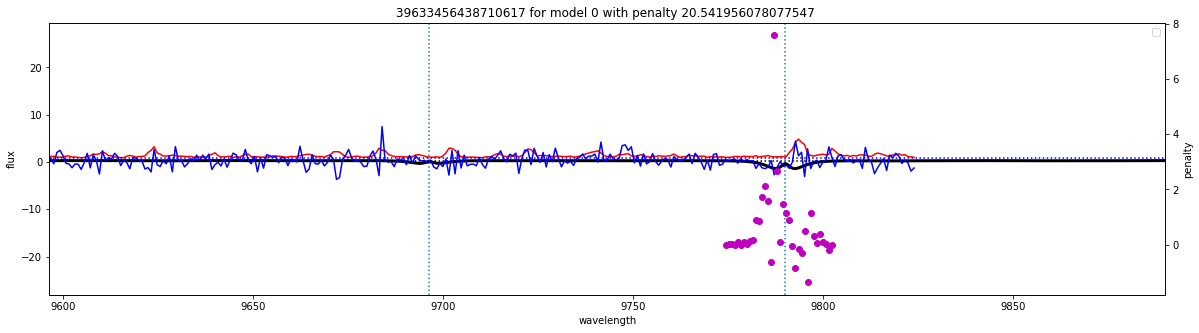

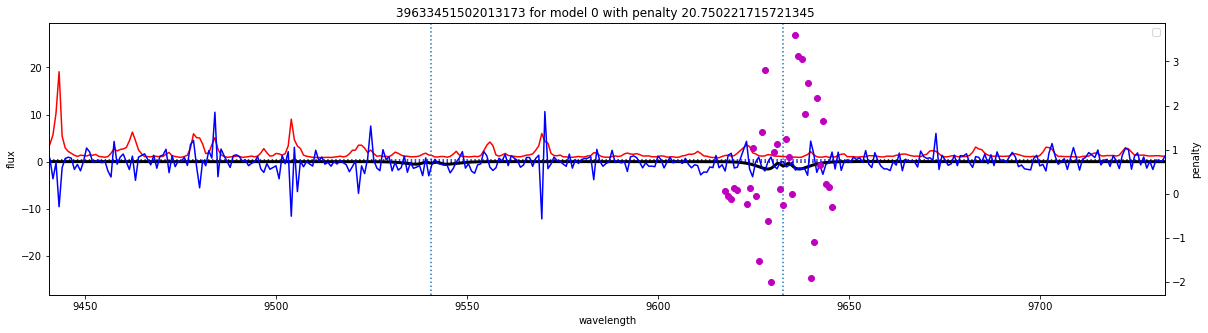

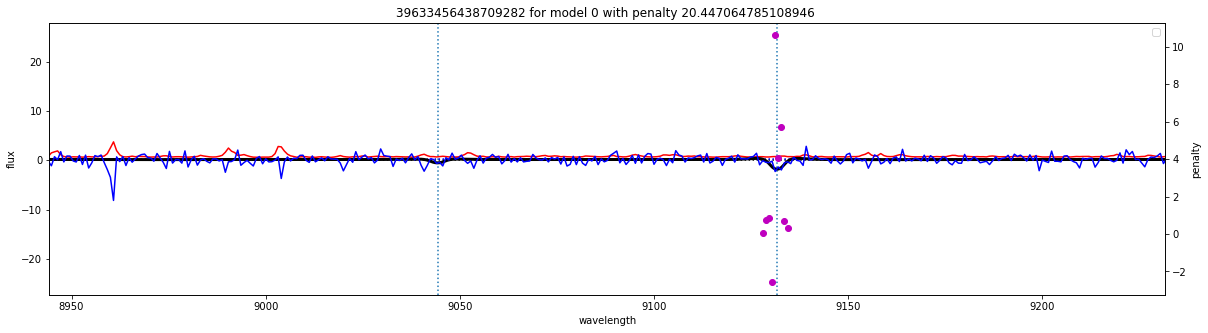

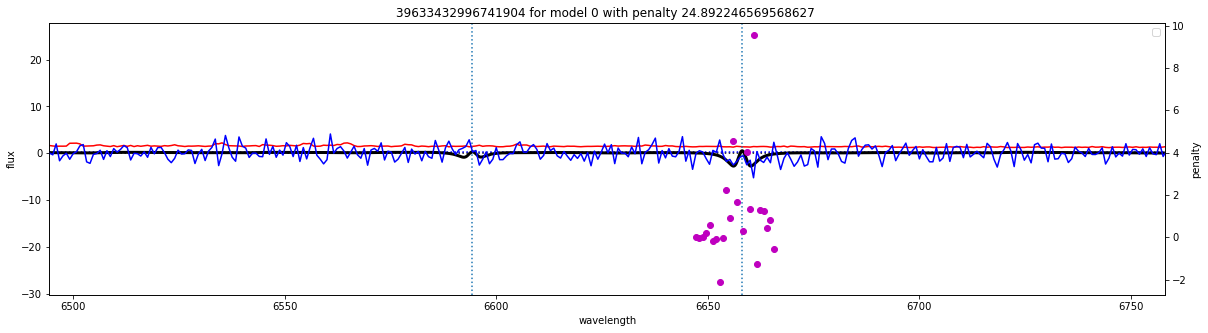

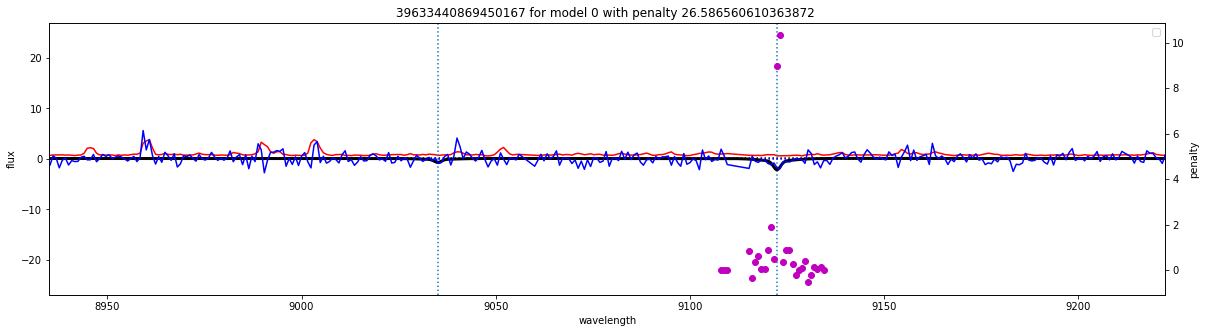

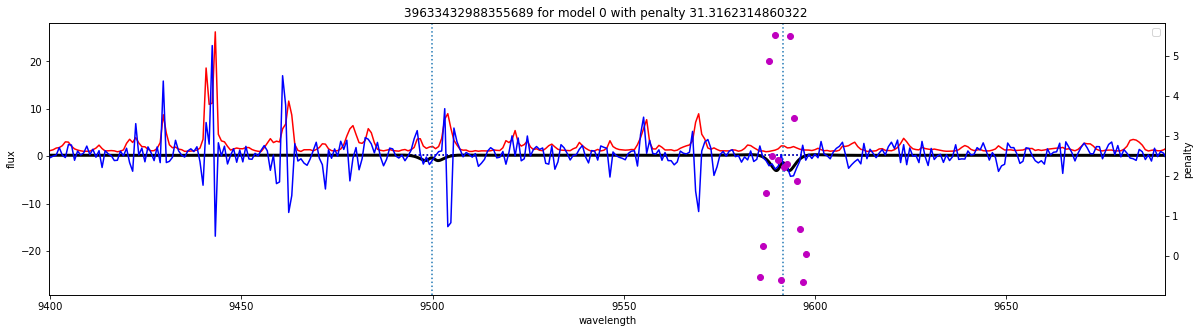

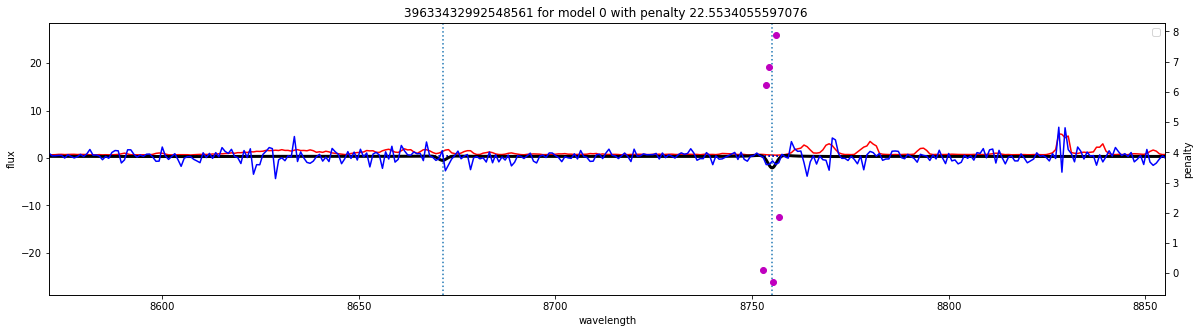

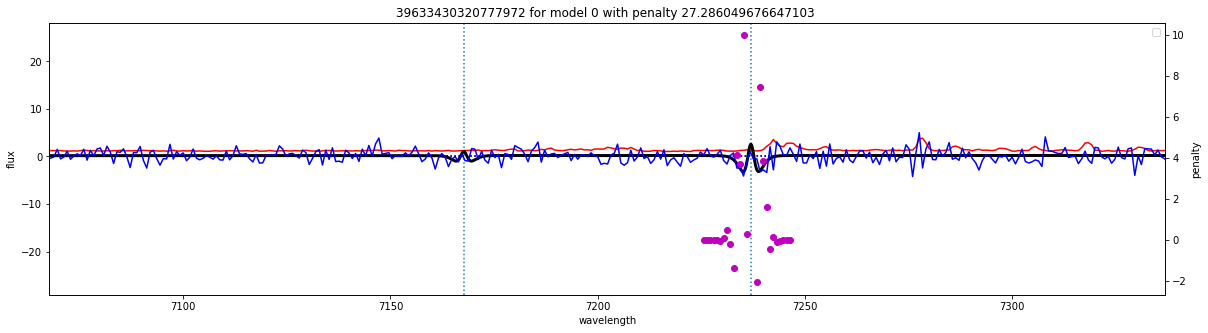

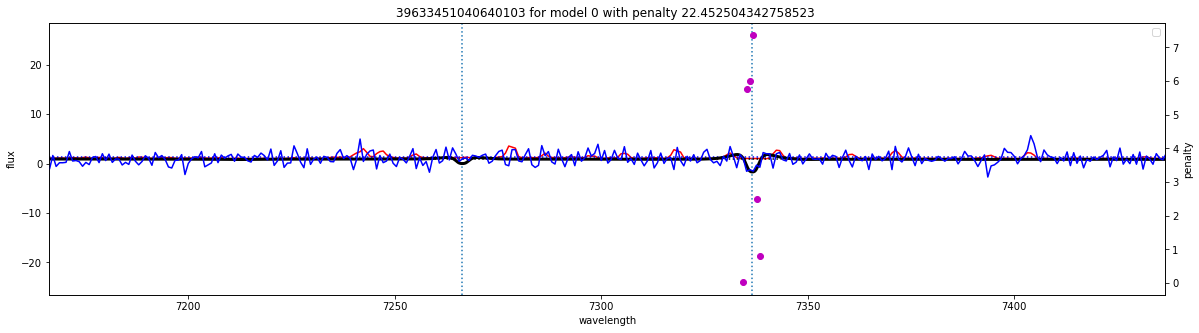

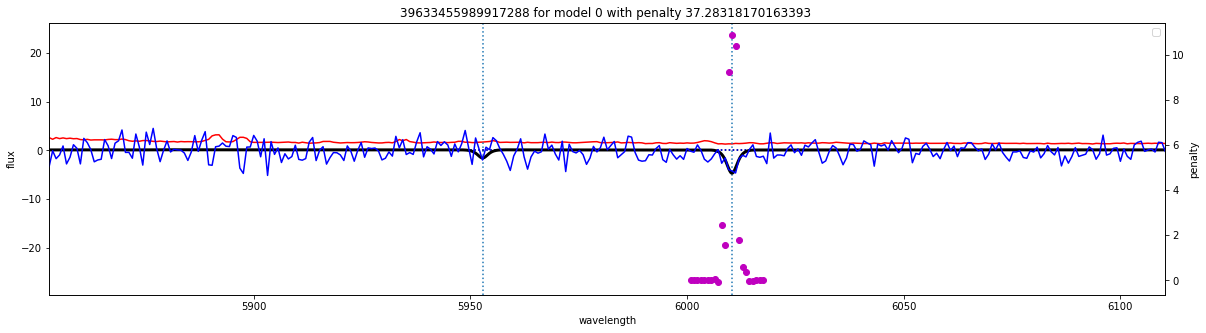

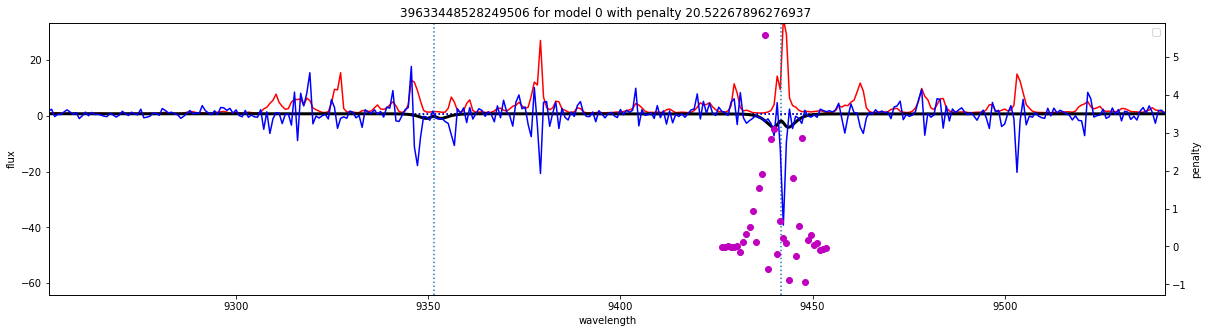

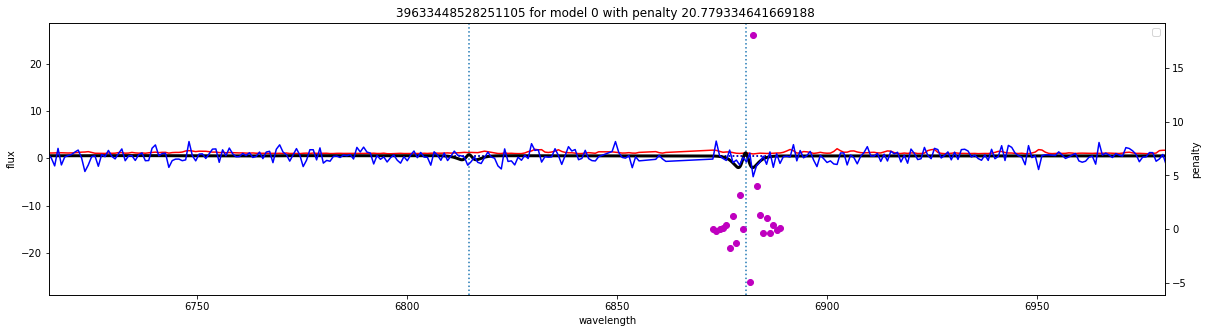

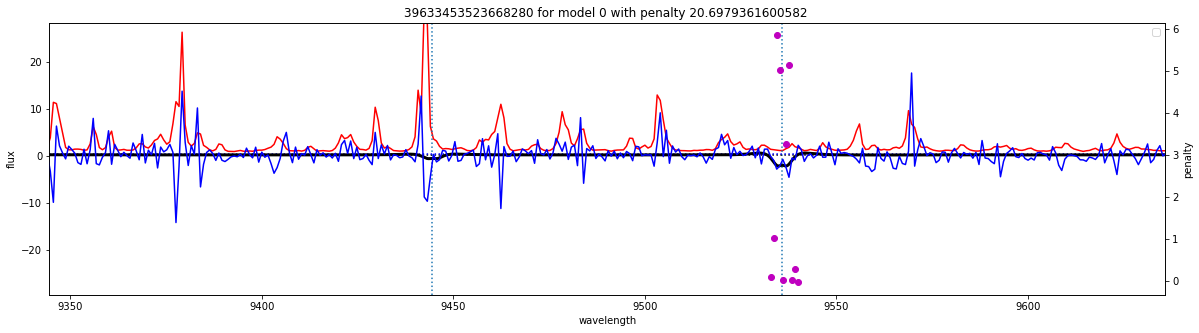

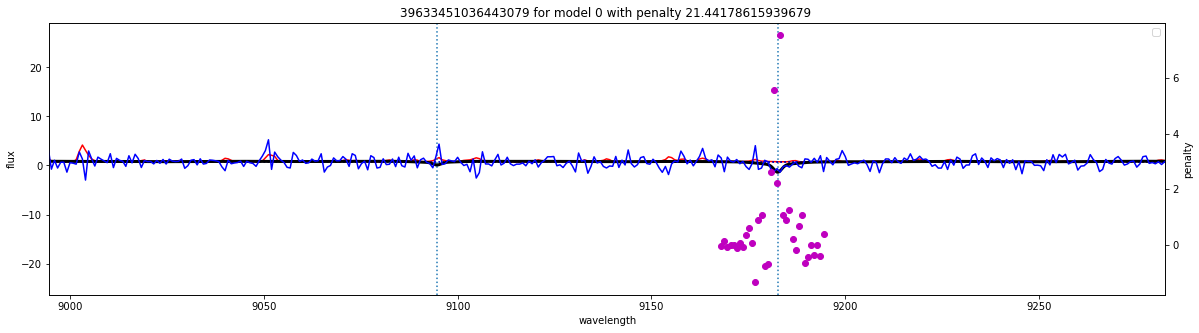

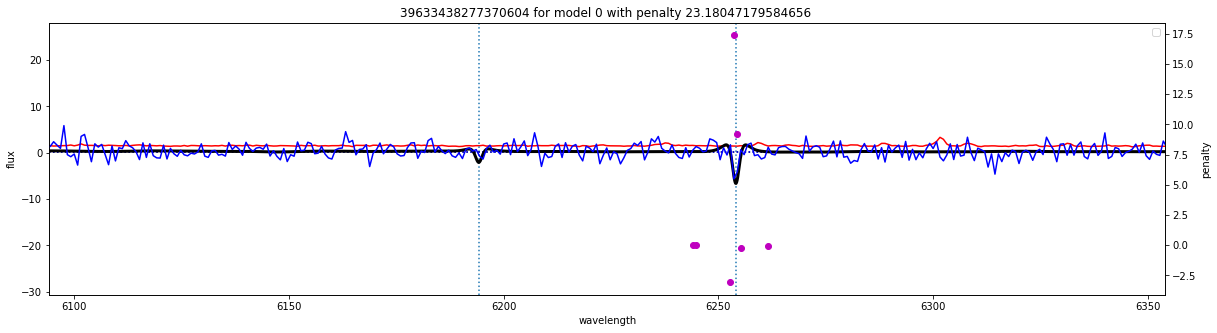

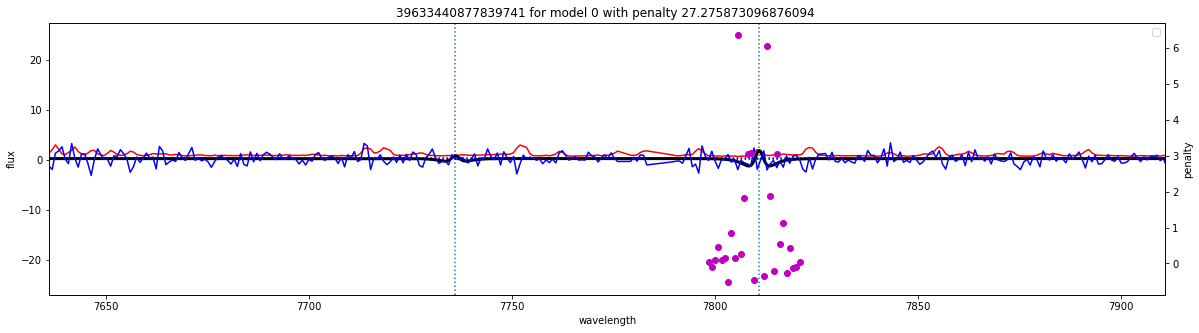

In [13]:
# Calculating the penalties
penallmodel=[]
testcount=0
for k in range(0,9):
 pen=[]   
 for j in range(0,len(catalog)):
     linemin=5000*(1+z[j][k])
     linemax=5015*(1+z[j][k])
     line=linemax-linemin
     if(linemax>9824):
            pen.append(0)
            continue
     cont1min=4980*(1+z[j][k])
     cont1max=4990*(1+z[j][k])
     cont1=cont1max-cont1min
     cont2min=5025*(1+z[j][k])
     cont2max=5035*(1+z[j][k])
     cont2=cont2max-cont2min
     binmodline,q,_=bn(xi[j][k],mi[j][k], bins=np.arange(linemin,linemax,0.8))
     binmodcont1,x,_=bn(xi[j][k],mi[j][k], bins=np.arange(cont1min,cont1max,0.8))
     binmodcont2,_,_=bn(xi[j][k],mi[j][k], bins=np.arange(cont2min,cont2max,0.8))
     bindatline=[]
     bindatcont1=[]
     bindatcont2=[]
     binsigline=[]
     binsigcont1=[]
     binsigcont2=[]
     wdaty=[]
     datx=[]
     sigy=[]  
     wl=[]
     daty=[]
     binwdatline=[]
     for i in range(0,3):
      datydum=outdict[tid[j]]['flux'][i][outdict[tid[j]]['mask'][i]==0]
      datxdum=outdict[tid[j]]['wave'][i][outdict[tid[j]]['mask'][i]==0]
      sigydum=outdict[tid[j]]['ivar'][i][outdict[tid[j]]['mask'][i]==0] 
      # datplot, =plt.plot(datxdum,datydum,zorder=10)
      # sigplot, =plt.plot(datxdum,sigydum)
      daty.extend(datydum)
      datx.extend(datxdum)
      sigy.extend(sigydum)
     daty=np.array(daty)
     datx=np.array(datx)
     sigy=np.array(sigy)
     #merging data for all 3 bands in OIII line   
     wdaty=daty*sigy
     dum,q,_=bn(datx,wdaty, bins=np.arange(linemin,linemax,0.8),statistic='sum')
     binwdatline=dum
     dum,_,_=bn(datx,sigy, bins=np.arange(linemin,linemax,0.8),statistic='sum')
     binsigline=dum
     dum,_,_=bn(datx,datx, bins=np.arange(linemin,linemax,0.8))
     binwaveline=dum
     merdatline=np.array(binwdatline)/np.array(binsigline)
     #finding the data continuum average by merging the data for 3 bands
     wdatcont=wdaty[((datx>cont1min) & (datx<cont1max)) + ((datx>cont2min) & (datx<cont2max)) ]
     sigcont=sigy[((datx>cont1min) & (datx<cont1max)) + ((datx>cont2min) & (datx<cont2max)) ]
     avgdatcont=np.nansum(wdatcont)/np.nansum(sigcont)
     #finding the model continuum average
     cont1modelsg,_,_=bn(datx,sigy, bins=np.arange(cont1min,cont1max,0.8),statistic='sum')
     cont2modelsg,_,_=bn(datx,sigy, bins=np.arange(cont2min,cont2max,0.8),statistic='sum')
     wmodcont=np.nansum(np.concatenate([cont1modelsg*binmodcont1,cont2modelsg*binmodcont2]))/np.nansum(np.concatenate([cont1modelsg,cont2modelsg]))
     # uwmodcont=np.nansum(np.concatenate([binmodcont1,binmodcont2]))
        
        
     csd=merdatline-avgdatcont
     csm=binmodline-wmodcont
     binpenoiii=csm[(csm<0)]*(2*csd[(csm<0)]-csm[(csm<0)])*binsigline[(csm<0)]
     penoiii=np.nansum(binpenoiii)
     counter=0
     if penoiii>20 and k==0:
            counter+=1
            # print(binpenoiii[binpenoiii>0])
            plt.figure(figsize=(20,5))
            plt.title(f'{tid[j]} for model {k} with penalty {penoiii} ')
            plt.plot(xi[j][k],mi[j][k],zorder=10,color='k',label='model',linewidth=3)
            datplot, =plt.plot(datx,daty,color='b',zorder=10)
            sigplot, =plt.plot(datx,1/sigy**0.5,color='r')
            datplot.set_label('data')
            sigplot.set_label('sigma')
            plt.xlim(4960.295*(1+z[j][k])-100,5008.239*(1+z[j][k])+100)
            # plt.xlim(3700*(1+z[j][k]),3800*(1+z[j][k]))
            #plt.ylim(-50,30)
            plt.ylim(np.nanmin(merdatline)-25,np.nanmax(merdatline)+25)
            plt.axvline(4960.295*(1+z[j][k]),ls=':',label='OIII doublet positions')
            plt.axvline(5008.239*(1+z[j][k]),ls=':')
            plt.ylabel('flux')
            
            plt.axvline(3726.1*(1+z[j][k]),ls=':',color='g',label='OII doublet positions')
            plt.axvline(3728.8*(1+z[j][k]),ls=':',color='g')
            plt.axhline(wmodcont,color="black",ls=':')
            plt.axhline(avgdatcont,color="blue",ls=':')
            plt.xlabel('wavelength')
            
            y2=plt.gca().twinx()
            y2.set_ylabel('penalty')
            y2.scatter(binwaveline[csm<0],binpenoiii,color='m',zorder=10)
            plt.legend(loc=0)
            plt.savefig('0')
            # print(binpenoiii, csd[csm<0], penoiii,avgdatcont,j,k)
            if counter>10:
                break
            
     pen.append(penoiii)
     # for plotting some data and model to check if it is alright (change u.l.(k) to 1 if you run it)
     # plt.figure(figsize=(20,5))
     # plt.title(tid[j])
     # plt.plot(xi[j][k],mi[j][k],zorder=10,color='k',label='model',linewidth=3)
     # datplot, =plt.plot(datx,daty,color='b',zorder=10)
     # sigplot, =plt.plot(datx,sigy,color='r')
     # datplot.set_label('data')
     # sigplot.set_label('sigma')
     # plt.xlim(4960.295*(1+z[j][k])-100,5008.239*(1+z[j][k])+100)
     # plt.ylim(-20,30)
     # plt.axvline(4960.295*(1+z[j][k]),ls=':',label='OIII doublet positions')
     # plt.axvline(5008.239*(1+z[j][k]),ls=':')
     # plt.xlabel('wavelength')
     # plt.ylabel('flux')
     # plt.legend(loc=0)
     # plt.savefig('0')
     # if j==9:
     #        break
 penallmodel.append(pen)

In [93]:
zsig.extend(z)
pensig.extend(np.array(penallmodel).T)
zchi2sig.extend(chi2)

In [77]:
zsig=[]
pensig=[]
zchi2sig=[]

In [82]:
#trick to cut merge the cut catalog results
chi2dum=np.array(chi2.copy())
pendum=np.array(penallmodel.copy())
zdum=np.array(z.copy())
# chi2mod=np.concatenate((penalty['chioiiif2000'],chi2dum),axis=0)
# penmod=np.concatenate((penalty['penoiiif2000'],pendum),axis=0)
# zmod=np.concatenate((penalty['zoiiif2000'],zdum),axis=0)
pendum=pendum.T

In [106]:
# Pickling data
data = {
     'chi2allmod':np.array(zchi2sig),
     'penallmod':np.array(pensig),
     'zallmod':np.array(zsig)
       }
with open('sigranoiii.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


In [ ]:
# Pickling data
data = {
     'chi2allmodsigo3':np.array(zchi2sig),
     'penallmodsigo3':np.array(pensig),
     'zmodsigo3':np.array(zsig)
       }
with open('sigoiiipen.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


# Extracting and displaying pickled data
with open('modelpenalty.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    penalty = pickle.load(f)

for i in penalty:
    print(i)
    

updatedchi2=penalty['chi2mod']+penalty['penmod']

In [83]:
updatedchi2=chi2dum+pendum

In [94]:
updatedchi2=np.array(zchi2sig)+np.array(pensig)

In [70]:
np.shape(updatedchi2)

(2187, 9)

In [95]:
dum=np.argmin(updatedchi2,axis=1)+1

In [96]:
np.shape(dum)

(4374,)

In [105]:
chi2new=updatedchi2.copy()
np.sort(chi2new,axis=1)
diff=chi2new[:,1]-chi2new[:,0]
print(len(diff[diff>40]))
print(len(catalog['DELTACHI2'][catalog['DELTACHI2']>40]))

471
474


In [26]:
1

1

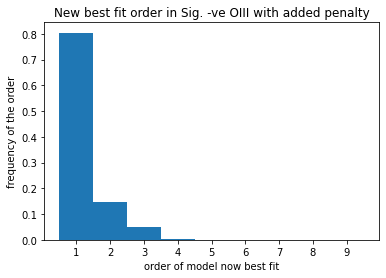

In [98]:
plt.figure()
plt.xticks(np.arange(1,10))
s=plt.hist(dum,bins=np.linspace(0.5,9.5,10),density=True)
plt.xlabel('order of model now best fit')
plt.ylabel('frequency of the order')
plt.title('New best fit order in Sig. -ve OIII with added penalty')
plt.savefig('hist.jpg')

In [99]:
s

(array([8.04069502e-01, 1.45861911e-01, 4.77823503e-02, 2.05761317e-03,
        0.00000000e+00, 2.28623685e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <BarContainer object of 9 artists>)

In [33]:
.872*500

436.0

In [17]:
l=np.sorted(pendum[:,0])
print(l)

AttributeError: module 'numpy' has no attribute 'sorted'

In [23]:
np.argwhere(dum==1)

array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 16],
       [ 17],
       [ 23],
       [ 24],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 31],
       [ 33],
       [ 34],
       [ 35],
       [ 38],
       [ 43],
       [ 45],
       [ 49],
       [ 53],
       [ 54],
       [ 57],
       [ 58],
       [ 59],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 68],
       [ 69],
       [ 70],
       [ 71],
       [ 72],
       [ 73],
       [ 74],
       [ 75],
       [ 76],
       [ 77],
       [ 78],
       [ 79],
       [ 82],
       [ 83],
       [ 84],
       [ 85],
       [ 86],
       [ 88],
       [ 89],
       [ 90],
       [ 91],
       [ 92],
       [ 93],
       [ 94],
       [ 96],
       [ 97],
       [ 99],
       [100],
       [101],
       [102],
       [105],
       [106],
       [110],
      

In [29]:
dumz=dum-1
print(np.shape(z),np.shape(dumz))
newz=z[dumz][dumz]

(500, 9) (500,)


TypeError: only integer scalar arrays can be converted to a scalar index

In [59]:
a=np.array([0,1,2])
b=np.array([1,2,3])
print(a*be)

[0 2 6]


In [26]:
pen=penalty['penbadoiii']
catalog=penalty['badoiii']

In [1]:
megapen=np.reshape(pendum,(4500))
x=np.repeat(catalog['DELTACHI2'],9)
plt.figure(figsize=(6,6))
plt.scatter(x,megapen,color='blue',zorder=100)
plt.ylim(-25,200)
plt.xlim(0,200)
plt.xlabel('$\Delta \u03d7^2$' )
plt.ylabel(' Proposed OIII Penalty')
x=np.linspace(0,200)
y=x
y2=x+40
y3=x-40
a4=np.minimum(y2,y3)
plt.plot(x,y,'k')
plt.plot(x,y2,color='gray')
plt.plot(x,y3,color='green')
plt.axvline(40,color='red')
plt.fill_between(x,0,y3,color='green',alpha=0.5)
plt.fill_between(x,y2,y3,color='yellow',alpha=0.5)
plt.fill_between(x,y2,400,x>40,color='red',alpha=0.5)
# plt.fill_betweenx(y,0,40,color='grey')
plt.fill_between(x,y2,400,x<41,color='cyan',alpha=0.5)
plt.fill_between(x,y2,y3,x<41,color='grey',alpha=0.5)
x=np.repeat(catalog['DELTACHI2'],9)
y=megapen
print(len(x[(x<40)*(x>0)*(y>0)*(y<x+40)])/len(x)*100,'% - GREY REGION')
print(len(x[(x<40)*(x>=0)*(y>x+40)])/len(x)*100,'% - BLUE REGION')
print(len(x[(x>40)*(y>x+40)])/len(x)*100,'% - RED REGION')
print(len(x[(x>40)*(y<x+40)*(y>x-40)])/len(x)*100,'% - YELLOW REGION')
print(len(x[(x>40)*(y<x-40)*(y>0)])/len(x)*100,'% - GREEN REGION')
print(len(x[np.isnan(y)])/len(x)*100,'% - UNCALCULATED REGION')
print(len(y[y==0])/len(x)*100,'% - ZERO Penalty')
print(len(x[(y<0)])/len(x)*100,'% - NEGATIVE PENALTIES')
plt.title('Penalty impact analysis on targets of Fuji tiles (80653-81115) with significantly negative OIII lines')
plt.savefig('pen')

NameError: name 'np' is not defined

36.96844993141289 % - GREY REGION
0.0 % - BLUE REGION
0.04572473708276177 % - RED REGION
0.11431184270690445 % - YELLOW REGION
2.880658436213992 % - GREEN REGION
0.0 % - UNCALCULATED REGION
39.34613625971651 % - ZERO Penalty
20.644718792866943 % - NEGATIVE PENALTIES
81.52720621856425 % - penalty<initial delchi2 


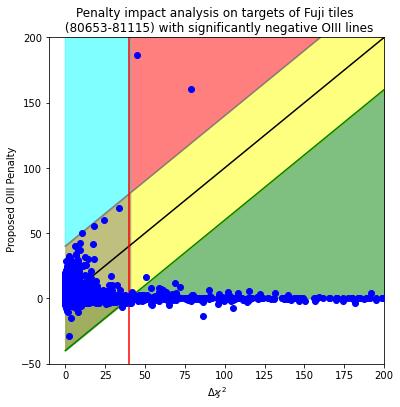

In [104]:

plt.figure(figsize=(6,6))
plt.scatter(catalog['DELTACHI2'],np.array(pensig)[:,0],color='blue',zorder=100)
plt.ylim(-50,200)
plt.xlim(-10,200)
plt.xlabel('$\Delta \u03d7^2$' )
plt.ylabel(' Proposed OIII Penalty')
x=np.linspace(0,200)
y=x
y2=x+40
y3=x-40
a4=np.minimum(y2,y3)
plt.plot(x,y,'k')
plt.plot(x,y2,color='gray')
plt.plot(x,y3,color='green')
plt.axvline(40,color='red')
plt.fill_between(x,0,y3,color='green',alpha=0.5)
plt.fill_between(x,y2,y3,color='yellow',alpha=0.5)
plt.fill_between(x,y2,400,x>40,color='red',alpha=0.5)
# plt.fill_betweenx(y,0,40,color='grey')
plt.fill_between(x,y2,400,x<41,color='cyan',alpha=0.5)
plt.fill_between(x,y2,y3,x<41,color='grey',alpha=0.5)
x=catalog['DELTACHI2']
y=np.array(pensig)[:,0]
print(len(x[(x<40)*(x>=0)*(y>0)*(y<x+40)])/len(x)*100,'% - GREY REGION')
print(len(x[(x<40)*(x>=0)*(y>x+40)])/len(x)*100,'% - BLUE REGION')
print(len(x[(x>40)*(y>x+40)])/len(x)*100,'% - RED REGION')
print(len(x[(x>40)*(y<x+40)*(y>x-40)])/len(x)*100,'% - YELLOW REGION')
print(len(x[(x>40)*(y<x-40)*(y>0)])/len(x)*100,'% - GREEN REGION')
print(len(x[np.isnan(y)])/len(x)*100,'% - UNCALCULATED REGION')
print(len(y[y==0])/len(x)*100,'% - ZERO Penalty')
print(len(x[(y<0)])/len(x)*100,'% - NEGATIVE PENALTIES')
print(len(x[(y<x)])/len(x)*100,'% - penalty<initial delchi2 ')
plt.title('Penalty impact analysis on targets of Fuji tiles \n (80653-81115) with significantly negative OIII lines')
plt.savefig('pen.jpg')

In [61]:
np.shape(catalog['DELTACHI2'])

(4374,)

In [14]:
max(pendum[:,0])

227.35045856676925

In [80]:
datx[((datx>cont1min) & (datx<cont1max)) + ((datx>cont2min) & (datx<cont2max)) ]

array([4972.8, 4973.6, 4974.4, 4975.2, 4976. , 4976.8, 4977.6, 4978.4,
       4979.2, 4980. , 4980.8, 4981.6, 5017.6, 5018.4, 5019.2, 5020. ,
       5020.8, 5021.6, 5022.4, 5023.2, 5024. , 5024.8, 5025.6, 5026.4])

In [166]:
csm

array([2.44073083e-03, 4.60095040e-03, 9.96657410e-03, 2.23538728e-02,
       5.10903643e-02, 1.20693788e-01, 2.91103795e-01, 7.00085979e-01,
       1.64258943e+00, 3.47419956e+00, 4.34435341e+00, 2.55279940e+00,
       1.12652417e+00, 4.76855594e-01, 2.00819342e-01, 8.75765750e-02,
       4.18793527e-02, 2.44888392e-02])

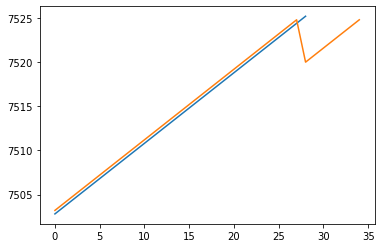

In [267]:
plt.plot(q)
plt.plot(datlinewave)

In [156]:
print(len(np.argwhere(pendum[:,0]>40))/len(pendum[:,0])*100)

1.0


In [111]:
len(new)

4500

In [273]:
np.arange(linemin,linemax,0.8)

array([8753.9999474, 8754.7999474, 8755.5999474, 8756.3999474,
       8757.1999474, 8757.9999474, 8758.7999474, 8759.5999474,
       8760.3999474, 8761.1999474, 8761.9999474, 8762.7999474,
       8763.5999474, 8764.3999474, 8765.1999474, 8765.9999474,
       8766.7999474, 8767.5999474, 8768.3999474, 8769.1999474,
       8769.9999474, 8770.7999474, 8771.5999474, 8772.3999474,
       8773.1999474, 8773.9999474, 8774.7999474, 8775.5999474,
       8776.3999474, 8777.1999474, 8777.9999474, 8778.7999474,
       8779.5999474])

TARGETID,Z,ZWARN,SPECTYPE,DELTACHI2,TARGET_RA,TARGET_DEC,OBJTYPE,OII_FLUX,OII_FLUX_IVAR,OII_SIGMA,OII_SIGMA_IVAR,OII_CONT,OII_CONT_IVAR,OII_SHARE,OII_SHARE_IVAR,OII_EW,OII_EW_IVAR,OII_CHI2,OII_NDOF,HDELTA_FLUX,HDELTA_FLUX_IVAR,HDELTA_SIGMA,HDELTA_SIGMA_IVAR,HDELTA_CONT,HDELTA_CONT_IVAR,HDELTA_SHARE,HDELTA_SHARE_IVAR,HDELTA_EW,HDELTA_EW_IVAR,HDELTA_CHI2,HDELTA_NDOF,HGAMMA_FLUX,HGAMMA_FLUX_IVAR,HGAMMA_SIGMA,HGAMMA_SIGMA_IVAR,HGAMMA_CONT,HGAMMA_CONT_IVAR,HGAMMA_SHARE,HGAMMA_SHARE_IVAR,HGAMMA_EW,HGAMMA_EW_IVAR,HGAMMA_CHI2,HGAMMA_NDOF,HBETA_FLUX,HBETA_FLUX_IVAR,HBETA_SIGMA,HBETA_SIGMA_IVAR,HBETA_CONT,HBETA_CONT_IVAR,HBETA_SHARE,HBETA_SHARE_IVAR,HBETA_EW,HBETA_EW_IVAR,HBETA_CHI2,HBETA_NDOF,OIII_FLUX,OIII_FLUX_IVAR,OIII_SIGMA,OIII_SIGMA_IVAR,OIII_CONT,OIII_CONT_IVAR,OIII_SHARE,OIII_SHARE_IVAR,OIII_EW,OIII_EW_IVAR,OIII_CHI2,OIII_NDOF,HALPHA_FLUX,HALPHA_FLUX_IVAR,HALPHA_SIGMA,HALPHA_SIGMA_IVAR,HALPHA_CONT,HALPHA_CONT_IVAR,HALPHA_SHARE,HALPHA_SHARE_IVAR,HALPHA_EW,HALPHA_EW_IVAR,HALPHA_CHI2,HALPHA_NDOF,RRFN,FN,COADDFN,RRN
int64,float64,int64,str6,float64,float64,float64,str3,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,str107,str106,str105,str107
39633441364377647,0.7507999894808937,4,GALAXY,0.6701565459370613,290.6802058263093,64.72016113001624,TGT,10.38238,0.04974444,0.820706,5.9777174,0.029986745,0.30865204,0.5383993,30.38479,606.1835,1.4592513e-05,31.020422,178,6.7608404,0.0388857,2.4083006,0.22090913,0.3344146,0.44497064,--,--,35.39582,0.0014186894,48.07423,173,12.505358,0.0059673414,2.8170142,0.11964356,0.27764946,0.47533125,--,--,78.856186,0.00015007265,505373.4,284,3.7112033,0.04184714,6.4888587,0.010993748,0.46364844,0.9625844,--,--,14.014012,0.0029347446,4.063467,173,-114038376.0,1.11881255e+26,0.048434995,11747.649,0.5173972,1.2520652,0.744,inf,-385889950.0,9.770852e+24,52.461704,278,--,--,--,--,--,--,--,--,--,--,--,-99,/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/redrock-8-81115-thru20210513.fits,/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/emline-8-81115-thru20210513.fits,/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/coadd-8-81115-thru20210513.fits,/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/rrdetails-8-81115-thru20210513.h5
39633438763912066,0.7355112771246516,4,GALAXY,4.001241754740477,290.4951593514464,64.46749805730705,TGT,-10.592096,0.032881524,4.3872585,0.102913514,0.5232167,0.46997517,0.1,2.2879488,-35.134014,0.0029885483,5.4648647,177,9.980478,0.02182356,10.0,0.016275855,0.30580717,0.664503,--,--,56.64103,0.00067758857,2.519839,172,8.305769,0.022978738,5.539599,0.037991807,0.37274066,0.6628501,--,--,38.672348,0.0010599486,1229.9276,277,2.0685544,0.29064015,1.4574575,0.440002,0.34145233,1.8095363,--,--,10.51391,0.011250217,12.492166,171,-8.37166,0.16851786,1.5387752,3.5911453,0.44166774,1.8539023,0.744,inf,-32.89602,0.010913961,1.5947913,275,--,--,--,--,--,--,--,--,--,--,--,-99,/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/redrock-8-81115-thru20210513.fits,/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/emline-8-81115-thru20210513.fits,/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/coadd-8-81115-thru20210513.fits,/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/rrdetails-8-81115-thru20210513.h5
39633441364379030,0.2150725179871444,4,GALAXY,2.96316572278738,290.8500092167183,64.83126825123622

In [51]:
len(catalog)

4374

In [2]:
data = h5py.File('/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/rrdetails-6-81115-thru20210513.h5', mode='r')

In [3]:
data

<HDF5 file "rrdetails-6-81115-thru20210513.h5" (mode r)>

In [4]:
data.keys()

<KeysViewHDF5 ['targetids', 'zfit', 'zscan']>

In [12]:
data['zfit']['39633446464653830']['zfit'][:]

array([(39633446464653830,  1.66146068e+00, 5.51747556e-04, 4, 7624.7695211 , [ 1.65882222e+00,  1.65926002e+00,  1.65969782e+00,  1.66013562e+00,  1.66057342e+00,  1.66101122e+00,  1.66144902e+00,  1.66188683e+00,  1.66232463e+00,  1.66276243e+00,  1.66320023e+00,  1.66363803e+00,  1.66407583e+00,  1.66451363e+00,  1.66495144e+00], [7626.78860951, 7625.83513004, 7625.81857764, 7626.4963839 , 7626.26840591, 7625.43309695, 7624.76996717, 7625.36606216, 7626.59001602, 7627.94875867, 7629.04937499, 7628.98300291, 7628.18475749, 7628.43619341, 7629.08380306], [ 1.63783741e-04, -5.84146784e-04,  3.91577263e-04,  6.80439184e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00], 7929, b'QSO', b'',  4, 0,  0.04059871),
       (39633446464653830,  1.65165156e+00, 7.06076856e-04, 4, 7624.81011981, [ 1.64660604e+00,  1.64704183e+00,  1.64747762e+00,  1.64791341e+00,  1.64834920e+00,  1.64878499e+00,  1.64922078e+00,  1.64965657e+00,  1.65009236

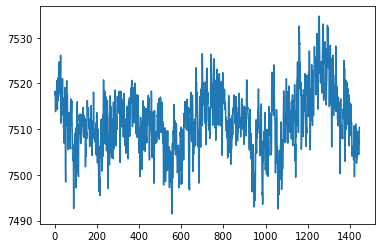

In [41]:
plt.plot(data['zscan']['GALAXY']['zchi2'][0])

In [23]:
np.shape(xi)

NameError: name 'xi' is not defined